## Batch Evaluation
Set the folder parameter. Get an anaysis about all included batch evals

In [13]:
# import
import seaborn as sns
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import json
import os
import pathlib

#set path to folder
folder = "../../../eval-results/_server-results/test2"

In [18]:
#fetch data 
dir_list = next(os.walk(folder))[1]
dfs = []
#merge all 
for subfolder in dir_list:
    print(subfolder)
    evalFile = folder +"/" + subfolder +"/aggRetrospectiveResults.eval"
    confFile = folder +"/" + subfolder +"/config.log"
    if os.path.exists(evalFile):
        df = pd.read_csv(evalFile ,encoding="ISO-8859-1", skipinitialspace=True)
        with open(confFile) as json_file:
            conf = json.load(json_file)
        
        df['matcher'] = conf['matcher']['ilp'] + " - " + conf['matcher']['profile'] +" - " + str(conf['matcher']['word-sim']) + " - sim-weight=" + str(conf['matcher']['sim-weight']) + " - postprocessing=" + str(conf['matcher']['postprocessing-thresh']) 
        df['complex-matches'] = conf['matcher']['complex matches']
        df['profile'] = conf['matcher']['profile']
        df['ilp'] =  conf['matcher']['ilp']
        df['word-sim'] =  conf['matcher']['word-sim']
        df['sim-weight'] = conf['matcher']['sim-weight']
        df['postprocessing-threshold'] = conf['matcher']['postprocessing-thresh']
        
        df.set_index(['Name','matcher'])
        dfs.append(df)
df_combined = pd.concat(dfs)

#convert time
df_combined['OVERALL TIME'] = df_combined['OVERALL TIME'].map(lambda x: x / 1000000000.)
df_combined['BP TIME'] = df_combined['BP TIME'].map(lambda x: x / 1000000000.)
df_combined['LABEL-SIM TIME'] = df_combined['LABEL-SIM TIME'].map(lambda x: x / 1000000000.)
df_combined['LP TIME'] = df_combined['LP TIME'].map(lambda x: x / 1000000000.)


retrospective-batch-birth-BINARY-2019-11-21-16-02-59-199-BINARY-2019-11-21-17-08-44-597
retrospective-batch-birth-BINARY-2019-11-21-16-03-00-393-BINARY-2019-11-21-17-08-42-848
retrospective-batch-birth-BINARY-2019-11-21-16-03-00-393-BINARY-2019-11-21-17-14-01-052
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-289-BINARY-2019-11-21-17-14-00-1
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-245-BINARY-2019-11-21-17-08-40-976
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-596-BINARY-2019-11-21-17-14-01-785
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-245-BINARY-2019-11-21-17-13-59-098
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-199-BINARY-2019-11-21-17-14-02-84
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-596-BINARY-2019-11-21-17-08-43-564
retrospective-batch-birth-BINARY-2019-11-21-16-02-59-289-BINARY-2019-11-21-17-08-41-919


In [ ]:
#Filter Data on what we want to analyze

#set x axis
 df['matcher'] =  df['matcher']

    #filter frame for entries

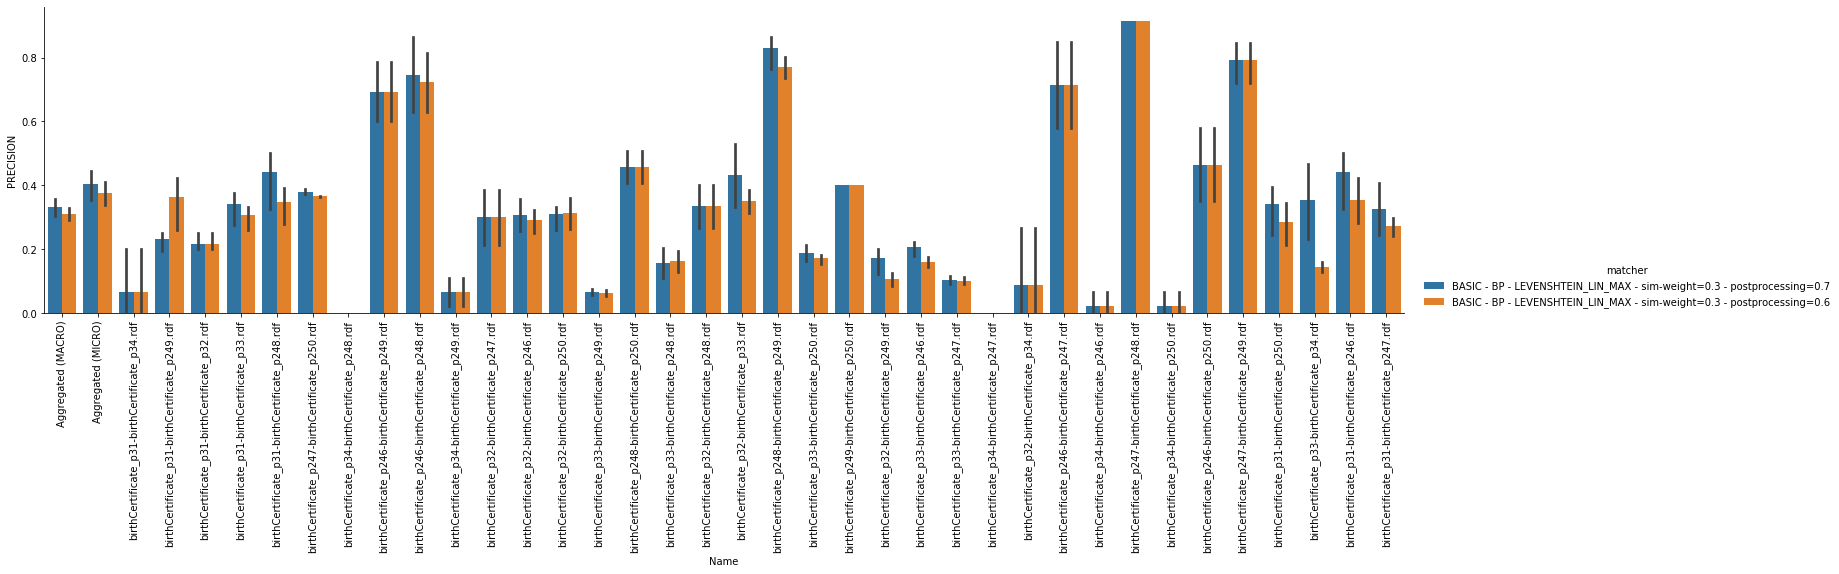

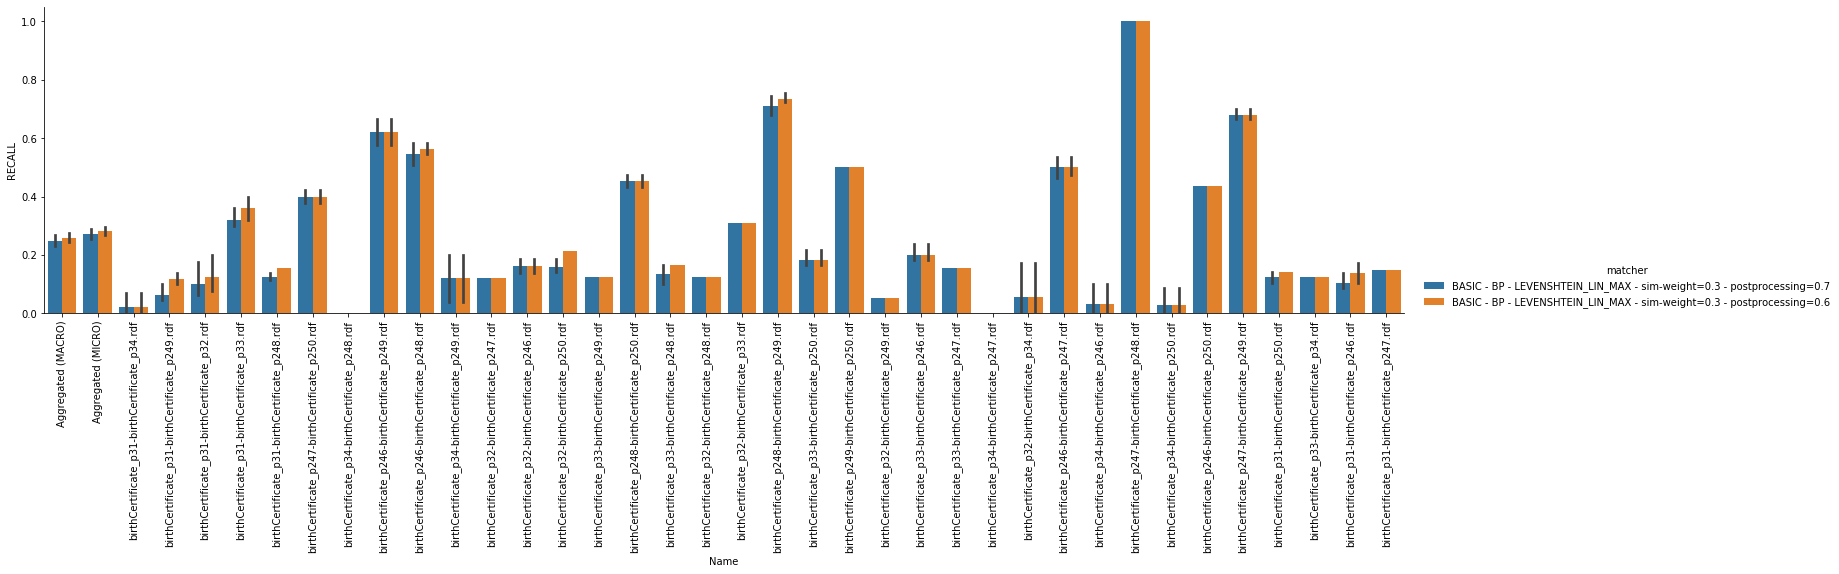

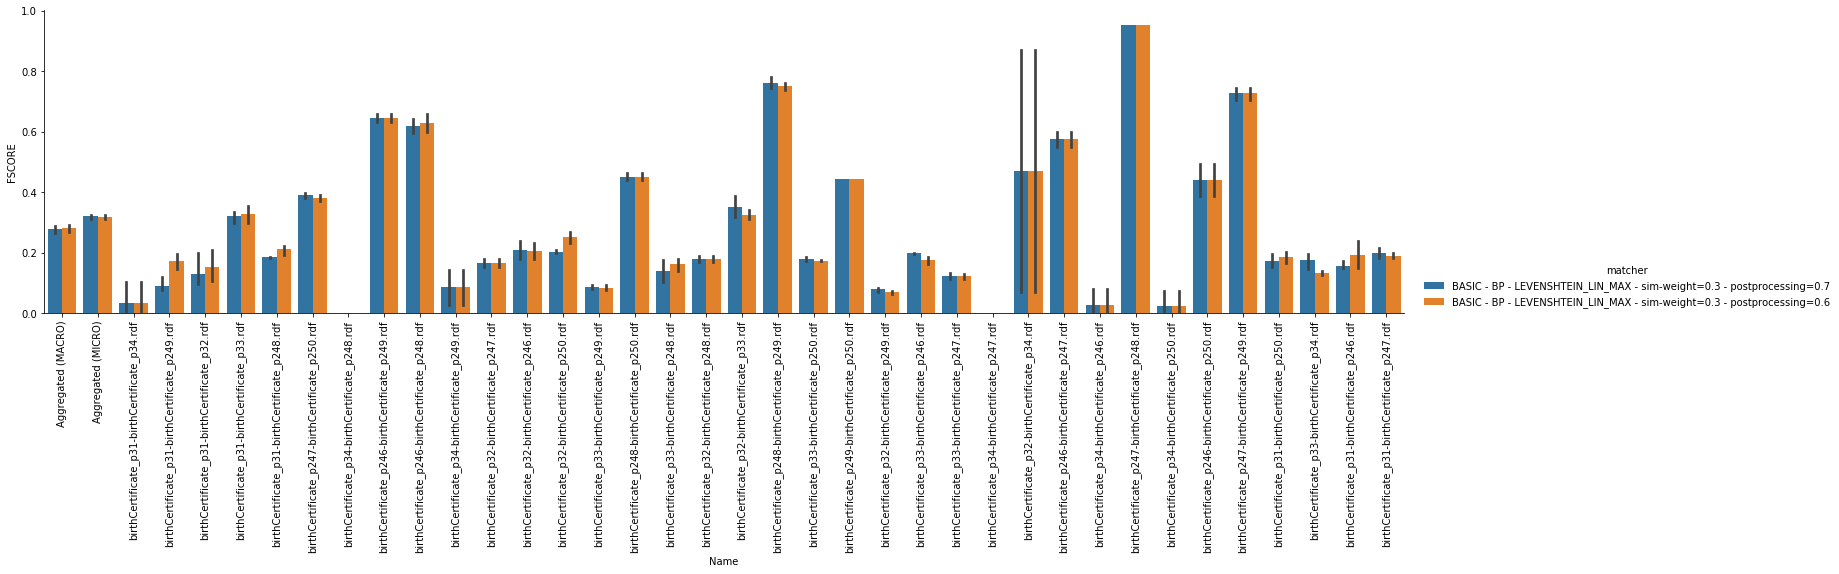

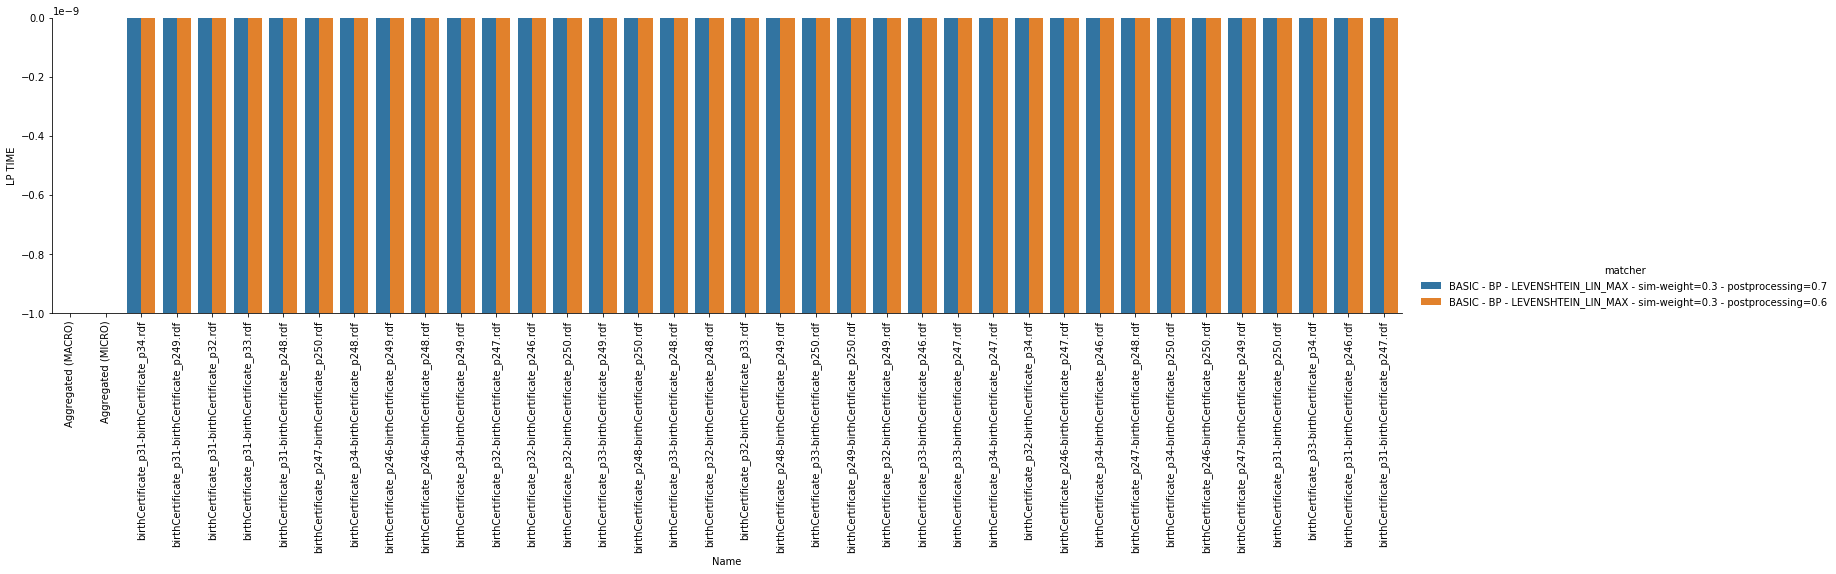

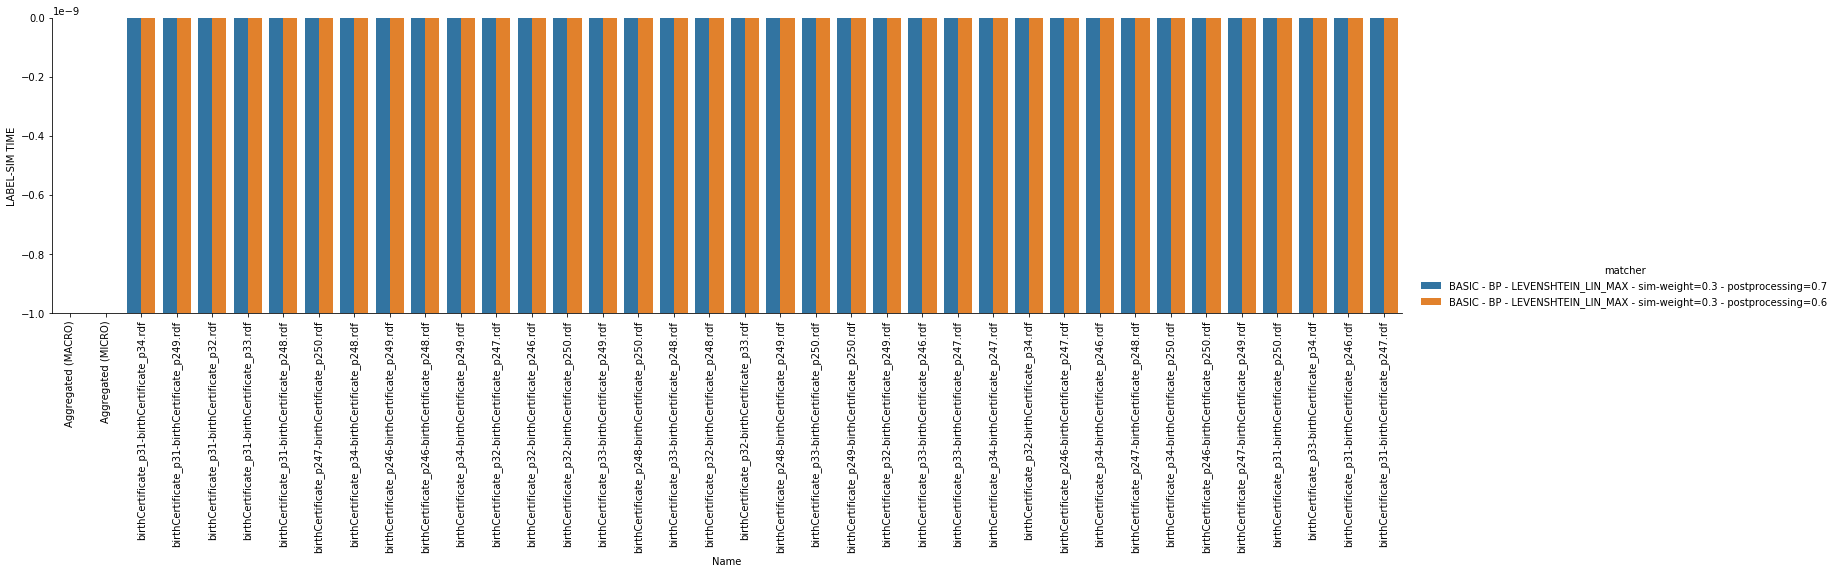

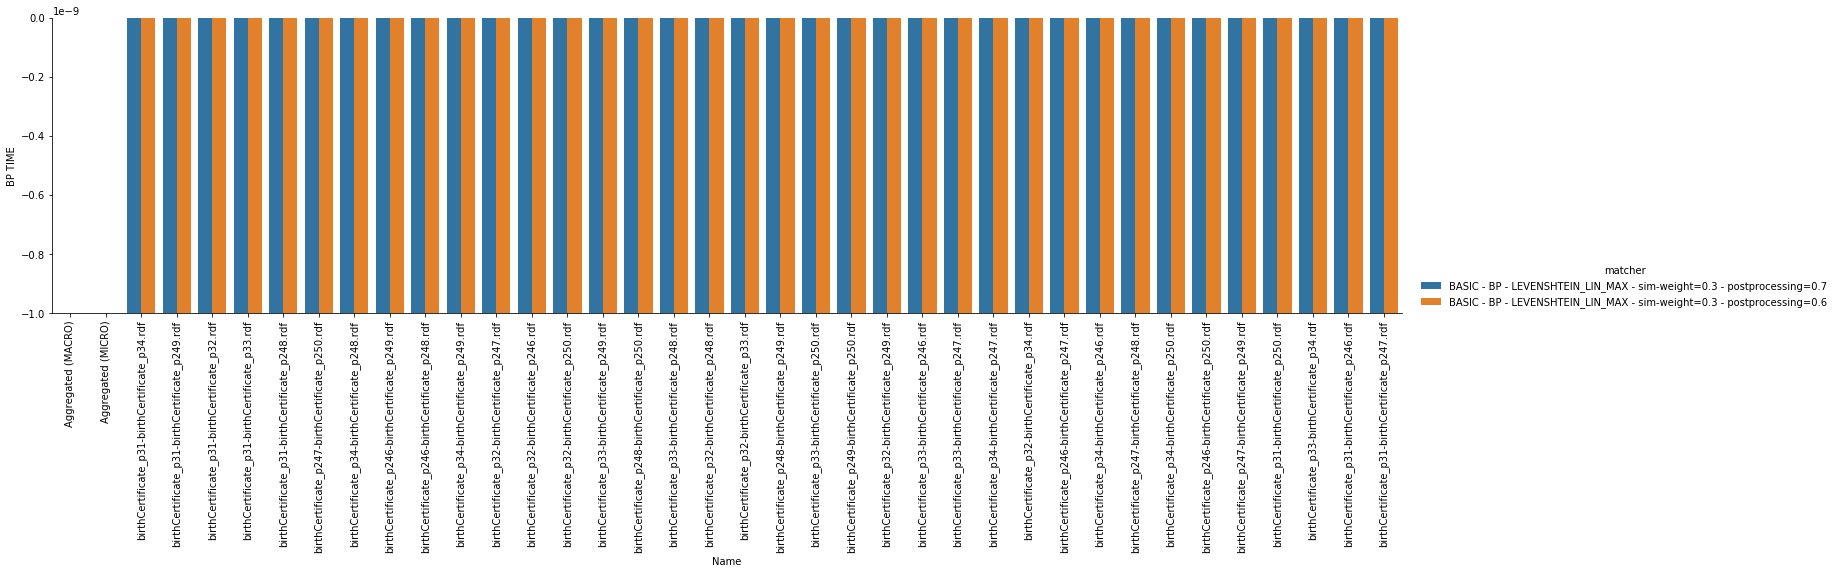

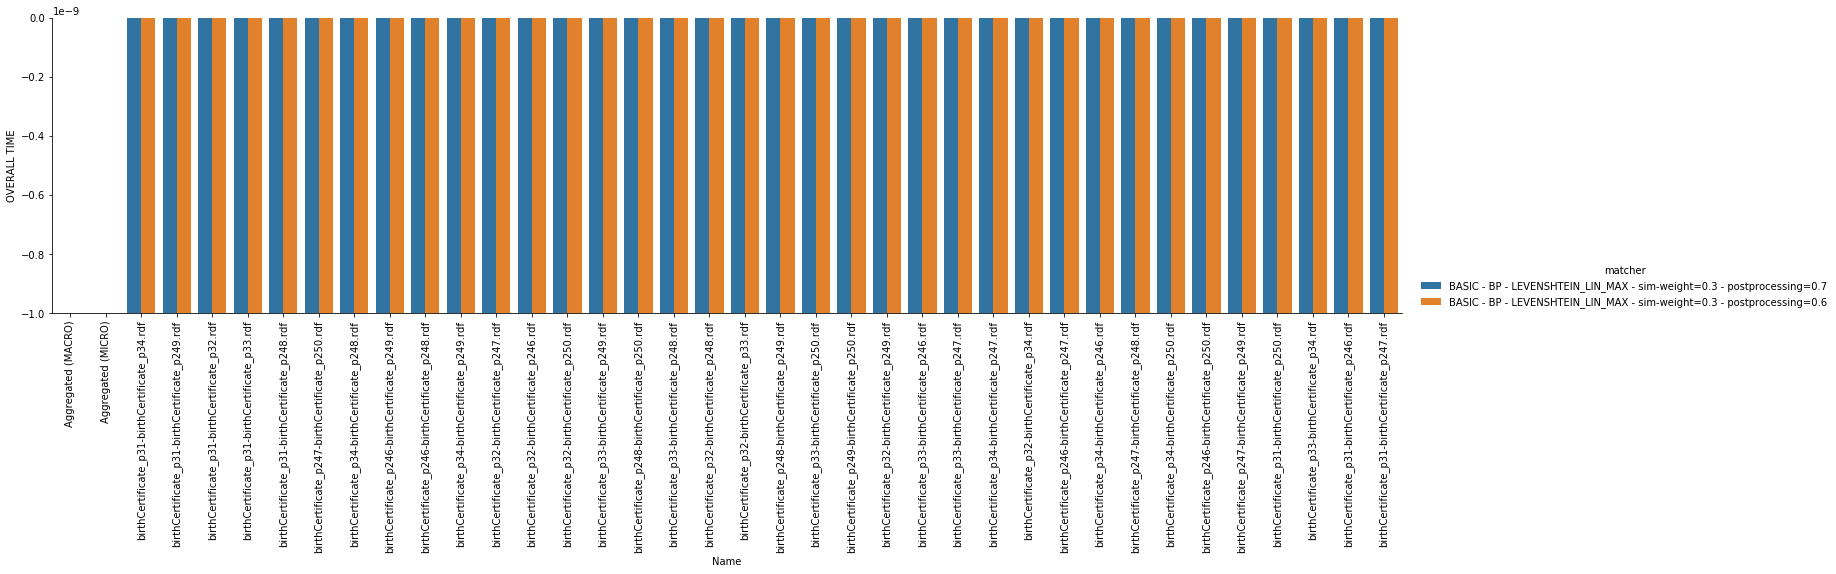

In [19]:
#BASIC VISUALIZATION

# visualize Precision 
g = sns.catplot(x="Name", y="PRECISION", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize Recall
g = sns.catplot(x="Name", y="RECALL", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

# Visualize FSCORE
g = sns.catplot(x="Name", y="FSCORE", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="LABEL-SIM TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="BP TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

#Visualize Runtime
g = sns.catplot(x="Name", y="OVERALL TIME", hue="matcher", kind="bar", data=df_combined,  height=5, aspect=4);
g.set_xticklabels(rotation=90)

